In [3]:
from aimon import *




In [ ]:
PCloudProjection = PCloudProjection()

In [1]:
import joblib
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import jaccard_score, f1_score, accuracy_score, matthews_corrcoef, cohen_kappa_score
import pandas as pd
import json
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set current directory to the location of the notebook (works even if __file__ is not defined)
try:
    current_dir = os.path.dirname(os.path.abspath(__file__))
except NameError:
    current_dir = os.getcwd()

os.chdir(current_dir)

def load_and_prepare_data_for_training(labelled_file):
    """
    Load and prepare the data for training.
    """
    labelled_coll = load_change_events(labelled_file)
    # Extract features from the labeled change events
    features_df = extract_features(labelled_coll)
    #remove_undefined
    features_df = features_df[features_df['event_type'] != "undefined"]
    features_df = features_df.dropna()
    if features_df.empty:
        raise ValueError("No complete data available after dropping missing values.")
    features_df_without_id = features_df.drop(columns=['object_id',"event_type"])

    X = features_df_without_id.values
    y = features_df['event_type'].values
    return X,y, features_df_without_id.columns

def apply_trained_model_to_unlabelled_data(model, unlabelled_file, output_file):
    # Load the unlabelled data
    unlabelled_coll = load_change_events(unlabelled_file)
    # Extract features from the unlabelled data
    features_unlabelled_df = extract_features(unlabelled_coll)
    # Remove rows with na values
    features_unlabelled_df = features_unlabelled_df.dropna()
    if features_unlabelled_df.empty:
        raise ValueError("No complete data available after dropping missing values.")
    #Prepare 
    features_unlabelled_df_without_id = features_unlabelled_df.drop(columns=["object_id","event_type"])
    X_unlabelled = features_unlabelled_df_without_id.values
    y_unlabelled_pred = model.predict(X_unlabelled)
    features_unlabelled_df['event_type'] = y_unlabelled_pred

    # Mapping from object_id to the chosen cluster label and saving of results
    label_mapping = dict(zip(features_unlabelled_df['object_id'], features_unlabelled_df['event_type']))

    # Update the original events by matching them by object_id.
    for event in unlabelled_coll:
        obj_id = event.get('object_id')
        if obj_id in label_mapping:
            event['event_type'] = label_mapping[obj_id]
        else:
            # Mark events dropped due to missing features as None
            event['event_type'] = None

    # Save the updated events to a new JSON file.
    with open(output_file, 'w') as f:
        json.dump(unlabelled_coll, f, indent=4)    


def train_random_forest(X_train: np.ndarray, y_train: np.ndarray, param_grid: dict, random_state: 42):
    """
    Train a RandomForest model using GridSearchCV to determine the best hyperparameters.
    """
    # Initialize the RandomForestClassifier with balanced class weighting
    rf = RandomForestClassifier(random_state=random_state, class_weight="balanced")
    
    # Set up and perform grid search with 3-fold cross-validation
    grid_search = GridSearchCV(estimator=rf,
                               param_grid=param_grid,
                               cv=3,
                               n_jobs=-1,
                               verbose=2)
    grid_search.fit(X_train, y_train)
    
    print("Best Hyperparameters:", grid_search.best_params_)
    return grid_search.best_estimator_, grid_search

# =============================================================================
# Model Evaluation and Visualization
# =============================================================================
def plot_confusion_matrix(y_test: np.ndarray, y_pred: np.ndarray):
    """
    Plot the confusion matrix using a heatmap.
    """
    fig, ax = plt.subplots(figsize=(10, 8))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')
    ax.set_title('Confusion Matrix')
    plt.show()

def plot_feature_importance(best_rf: RandomForestClassifier, features: pd.Index, X_train_shape: tuple):
    """
    Plot feature importances in descending order.
    """
    importances = best_rf.feature_importances_
    indices = np.argsort(importances)[::-1]
    
    plt.figure(figsize=(12, 8))
    plt.title("Feature Importances")
    plt.bar(range(X_train_shape[1]), importances[indices], align="center")
    plt.xticks(range(X_train_shape[1]), features[indices], rotation=90)
    plt.xlim([-1, X_train_shape[1]])
    plt.tight_layout()
    plt.show()

def evaluate_model(best_rf: RandomForestClassifier, X_test: np.ndarray, y_test: np.ndarray, labels: pd.DataFrame):
    """
    Evaluate the given model by printing the classification report, plotting the confusion matrix
    and feature importances, and printing additional performance metrics.
    """
    # Predict on the test set
    y_pred = best_rf.predict(X_test)
    
    # Print the classification report
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    
    # Plot the confusion matrix and feature importance
    plot_confusion_matrix(y_test, y_pred)
    plot_feature_importance(best_rf, labels, X_test.shape)
    
    # Compute and print additional metrics
    jaccard = jaccard_score(y_test, y_pred, average='macro')
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='macro')
    mcc = matthews_corrcoef(y_test, y_pred)
    kappa = cohen_kappa_score(y_test, y_pred)
    
    print("Jaccard Score:", jaccard)
    print("Accuracy Score:", accuracy)
    print("F1 Score:", f1)
    print("Matthews Correlation Coefficient:", mcc)
    print("Cohen's Kappa:", kappa)


def save_model(model, file_path: str):
    """
    Save the trained model to disk using joblib.
    """
    joblib.dump(model, file_path)
    print(f"Model saved to {file_path}")

def load_model(file_path: str):
    """
    Load a machine learning model from disk using joblib.
    """
    model = joblib.load(file_path)
    print(f"Model loaded from {file_path}")
    return model

def load_change_events(change_events_file):
    """
    Load the change events from a JSON file.
    """
    if not os.path.exists(change_events_file):
        raise FileNotFoundError(f"{change_events_file} does not exist")
    with open(change_events_file, 'r') as f:
        events = json.load(f)
    return events

def extract_features(events):
    """
    Convert the change events into a feature matrix.
    This example assumes each event contains an "object_id".
    The features include:
      - Basic event info (e.g., delta_t_hours, number_of_points)
      - Change magnitude statistics (mean, std, min, max, median, quant90, quant95, quant99)
      - Convex hull properties (hull surface area, volume, and ratio)
      - Geometric features from both epochs
    """
    rows = []
    for event in events:
        row = {}
        # Basic features
        # row['delta_t_hours'] = event.get('delta_t_hours', np.nan)
        # row['number_of_points'] = event.get('number_of_points', np.nan)
        
        # Change magnitude statistics
        # change_mags = event.get('change_magnitudes', {})
        # for stat in ['mean', 'std', 'min', 'max', 'median', 'quant90', 'quant95', 'quant99']:
        #     row[f'change_{stat}'] = change_mags.get(stat, 0)

        # Change magnitude statistics
        change_mags = event.get('change_magnitudes', {})
        for stat in ['median']:
            row[f'change_{stat}'] = change_mags.get(stat, 0)

        # Convex hull properties
        convex_hull = event.get('convex_hull', {})
        # row['hull_surface_area'] = convex_hull.get('surface_area', 0)
        # row['hull_volume'] = convex_hull.get('volume', 0)
        row['hull_surf_vol_ratio'] = convex_hull.get('surface_area_to_volume_ratio', 0)
        
        # Geometric features from both epochs (if available)
        geom = event.get('geometric_features_both_epochs', {})
        for feat in ['sum_of_eigenvalues', 'omnivariance', 'eigentropy', 'anisotropy',
                     'planarity', 'linearity', 'surface_variation', 'sphericity', 'verticality']:
            row[f'geom_{feat}'] = geom.get(feat, 0)

        geo_epoch_1 = event.get('geometric_features_epoch_1', {})
        for feat in ['sum_of_eigenvalues', 'omnivariance', 'eigentropy', 'anisotropy',
                     'planarity', 'linearity', 'surface_variation', 'sphericity', 'verticality']:
            row[f'geo_epoch_1_{feat}'] = geo_epoch_1.get(feat, 0)

        geo_epoch_2 = event.get('geometric_features_epoch_2', {})
        for feat in ['sum_of_eigenvalues', 'omnivariance', 'eigentropy', 'anisotropy',
                     'planarity', 'linearity', 'surface_variation', 'sphericity', 'verticality']:
            row[f'geo_epoch_2_{feat}'] = geo_epoch_2.get(feat, 0)
        
        # Keep the unique identifier
        row['object_id'] = event.get('object_id')
        row["event_type"] = event.get('event_type', "undefined")
        
        rows.append(row)
    df = pd.DataFrame(rows)
    return df


In [2]:
# Path to the unlabelled change events test file
labelled_file = "../test_data/change_events_labelled.json"
unlabelled_file = "../test_data/change_events_unlabelled.json"
outfolder = "../test_data/out"

random_state = 3
# Define hyperparameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [True]
}

# Predefined paths for output
predicted_file = os.path.join(outfolder, "change_events_labelled_using_random_forest.json")
model_file = os.path.join(outfolder, "best_model.joblib")
os.makedirs(outfolder, exist_ok=True)

Fitting 3 folds for each of 405 candidates, totalling 1215 fits
Best Hyperparameters: {'bootstrap': True, 'max_depth': 10, 'max_features': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 50}
Classification Report:
                           precision    recall  f1-score   support

gravitationalMassMovement       0.85      0.83      0.84       363
               vegetation       0.78      0.80      0.79       263

                 accuracy                           0.82       626
                macro avg       0.81      0.82      0.82       626
             weighted avg       0.82      0.82      0.82       626



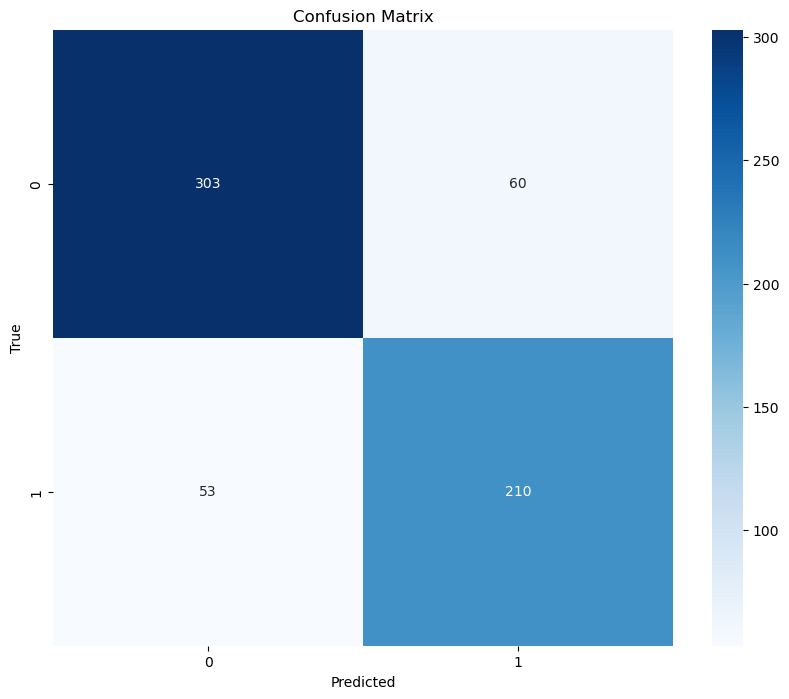

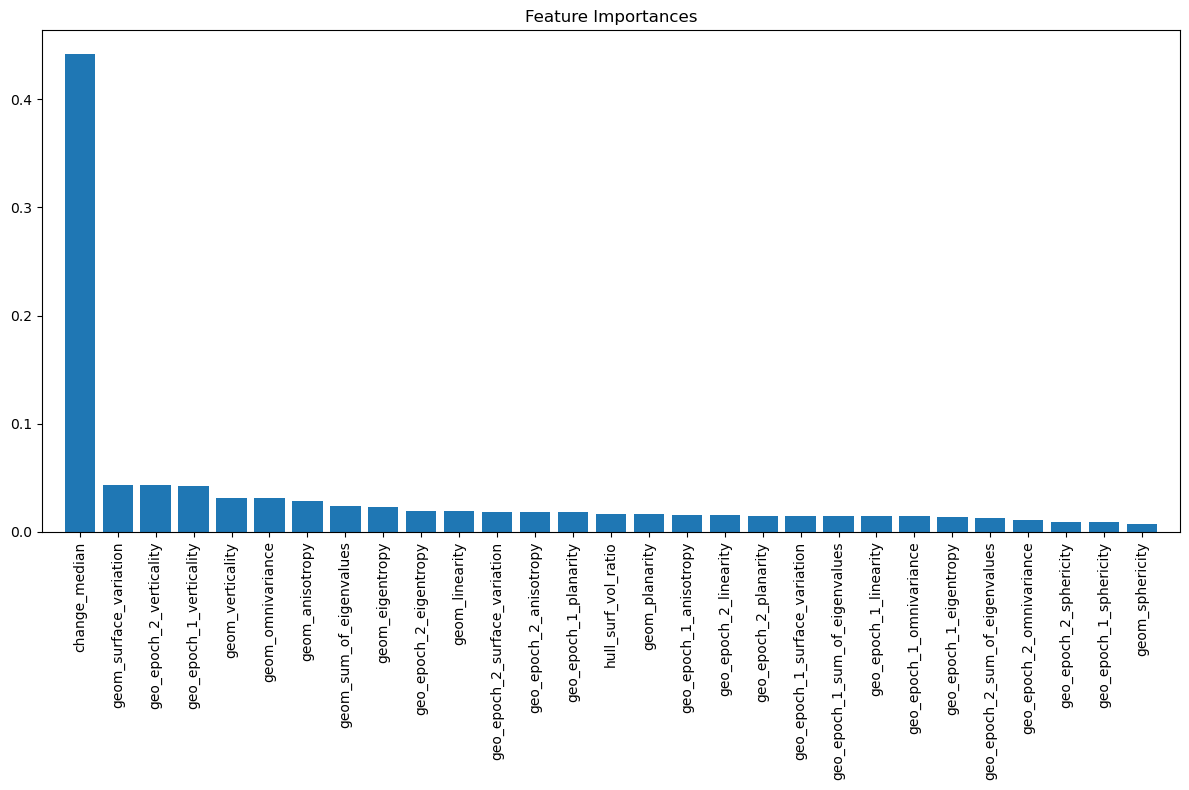

Jaccard Score: 0.6892600916884972
Accuracy Score: 0.8194888178913738
F1 Score: 0.8154148846506117
Matthews Correlation Coefficient: 0.6310419593218826
Cohen's Kappa: 0.6308769659462111


In [3]:
# Load and prepare the data for training
X, y, labels = load_and_prepare_data_for_training(labelled_file)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test =  train_test_split(X, y, test_size=0.2, random_state=random_state)

# Train model with grid search
best_rf, _ = train_random_forest(X_train, y_train, param_grid, random_state)

# Evaluate the trained model
evaluate_model(best_rf, X_test, y_test, labels)

# Apply the trained model to unlabelled data
apply_trained_model_to_unlabelled_data(best_rf, unlabelled_file, predicted_file)

### Optional: Save and load the model
save_model_to_disk = False
load_model_from_disk = False

if save_model_to_disk:
    # Save the trained model to disk
    save_model(best_rf, model_file)
if load_model_from_disk:
    # Load the model from disk
    load_model(model_file)
